In [1]:
import os
from Benchmark import Benchmark
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

output_dir = 'output'
bcast_bms = []
reduce_bms = []
for root, dirs, files in os.walk(output_dir):
    for file in files:
        bm = Benchmark(os.path.join(root, file))
        if bm.operation == 'bcast':
            bcast_bms.append(bm)
        elif bm.operation == 'reduce':
            reduce_bms.append(bm)

In [2]:
dfs = []
for bm in bcast_bms:
    full_df = bm.data
    full_df['Processes'] = bm.processes
    full_df['Algorithm'] = bm.algorithm
    full_df['Processes'] = full_df['Processes'].astype(int)
    dfs.append(full_df)

bcast_df = pd.concat(dfs, ignore_index=True)

dfs = []
for bm in reduce_bms:
    full_df = bm.data
    full_df['Processes'] = bm.processes
    full_df['Algorithm'] = bm.algorithm
    full_df['Processes'] = full_df['Processes'].astype(int)
    dfs.append(full_df)
    
reduce_df = pd.concat(dfs, ignore_index=True)

In [3]:
def plot_processes_vs_latency(df, msg_size, ax):
    df = df[df['Size'] == msg_size]
    for alg in df['Algorithm'].unique():
        alg_df = df[df['Algorithm'] == alg].sort_values(by='Processes')
        ax.plot(alg_df['Processes'], alg_df['Avg_Latency'], label=alg)

    ax.set_xlabel('Processes')
    ax.set_ylabel('Avg Latency')
    ax.set_title(f'Latency vs Processes for Size {msg_size}')
    ax.set_xticks(range(2, max(df['Processes']) + 1, 2))
    ax.axvline(12, color='r', linestyle='--')
    ax.axvline(24, color='r', linestyle='--')
    ax.axvline(36, color='r', linestyle='--')
    ax.axvline(48, color='r', linestyle='--')
    ax.legend()

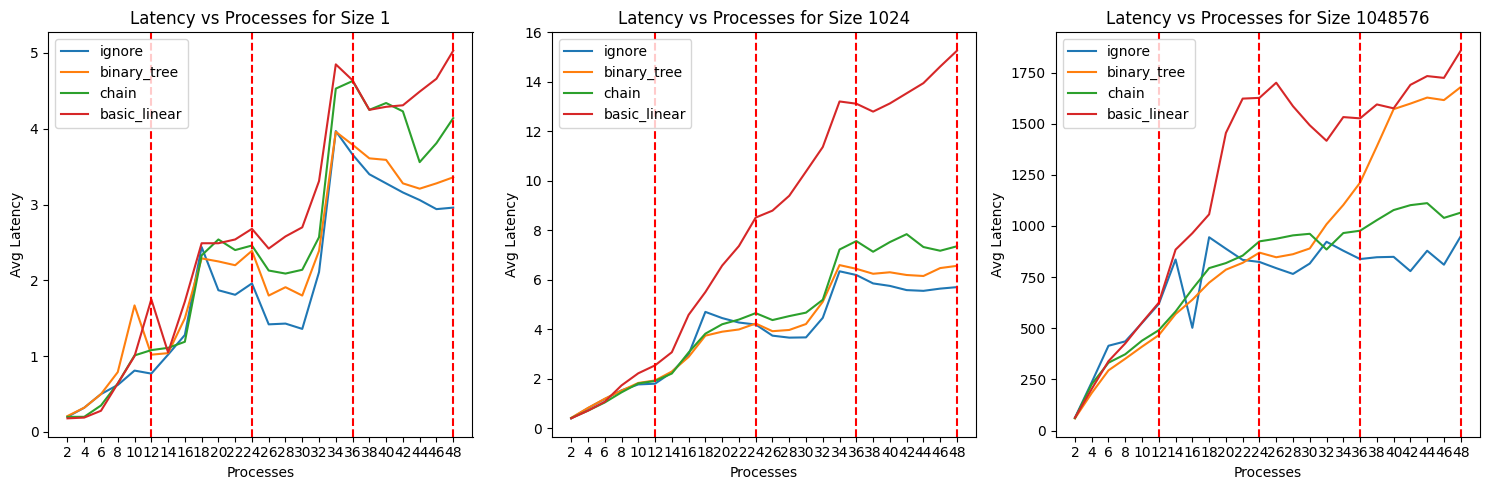

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_processes_vs_latency(bcast_df, 1, axs[0]) # 1 byte
plot_processes_vs_latency(bcast_df, 1024, axs[1]) # 1 KB
plot_processes_vs_latency(bcast_df, 1048576, axs[2]) # 1 MB

plt.tight_layout()
plt.show()

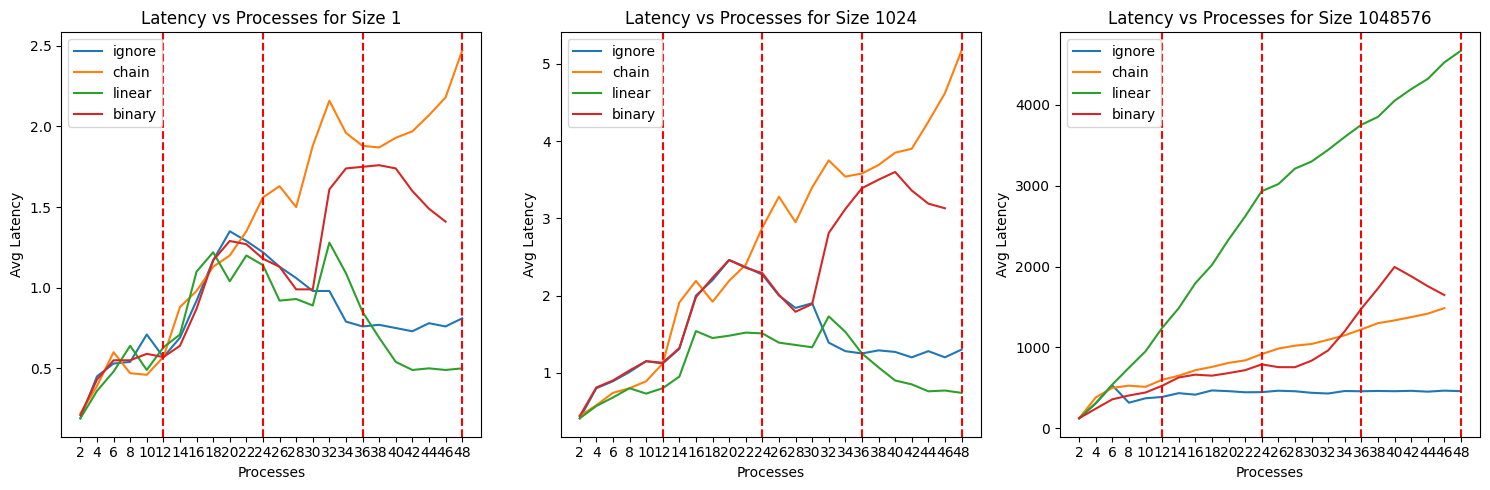

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_processes_vs_latency(reduce_df, 1, axs[0]) # 1 byte
plot_processes_vs_latency(reduce_df, 1024, axs[1]) # 1 KB
plot_processes_vs_latency(reduce_df, 1048576, axs[2]) # 1 MB

plt.tight_layout()
plt.show()

In [5]:
def plot_processes_vs_latency2(df, algorithm, msg_size, ax):
    df = df[(df['Algorithm'] == algorithm) & (df['Size'] == msg_size)].sort_values(by='Processes')
    ax.plot(df['Processes'], df['Avg_Latency'], label='Measured')
    ax.set_xlabel('Processes')
    ax.set_ylabel('Avg Latency')
    ax.set_title(f'Latency vs Processes for Size {msg_size}, Algorithm {algorithm}')
    ax.set_xticks(range(2, max(df['Processes']) + 1, 2))
    ax.axvline(12, color='r', linestyle='--')
    ax.axvline(24, color='r', linestyle='--')
    ax.axvline(36, color='r', linestyle='--')
    ax.axvline(48, color='r', linestyle='--')
    ax.legend()
    
# basic_linear should be predictable with L = k + a*m * x
# binary_tree should be predictable with L = k + a*m * log2(x)
def plot_pred_latency(df, algorithm, msg_size, ax, kernel='linear'):
    df = df[(df['Algorithm'] == algorithm) & (df['Size'] == msg_size)].sort_values(by='Processes')

    x = df['Processes']
    y = df['Avg_Latency']
    if kernel == 'log2':
        x = np.log2(x)
        # plot at 2, 4, 8, 16, 32 vertical lines
        ax.axvline(2, color='gray', linestyle='--')
        ax.axvline(4, color='gray', linestyle='--')
        ax.axvline(8, color='gray', linestyle='--')
        ax.axvline(16, color='gray', linestyle='--')
        ax.axvline(32, color='gray', linestyle='--')
        
    a, b = np.polyfit(x, y, 1)
    pred_latency = a*x + b

    ax.plot(df['Processes'], pred_latency, label=f'Predicted')

    ax.legend()
        

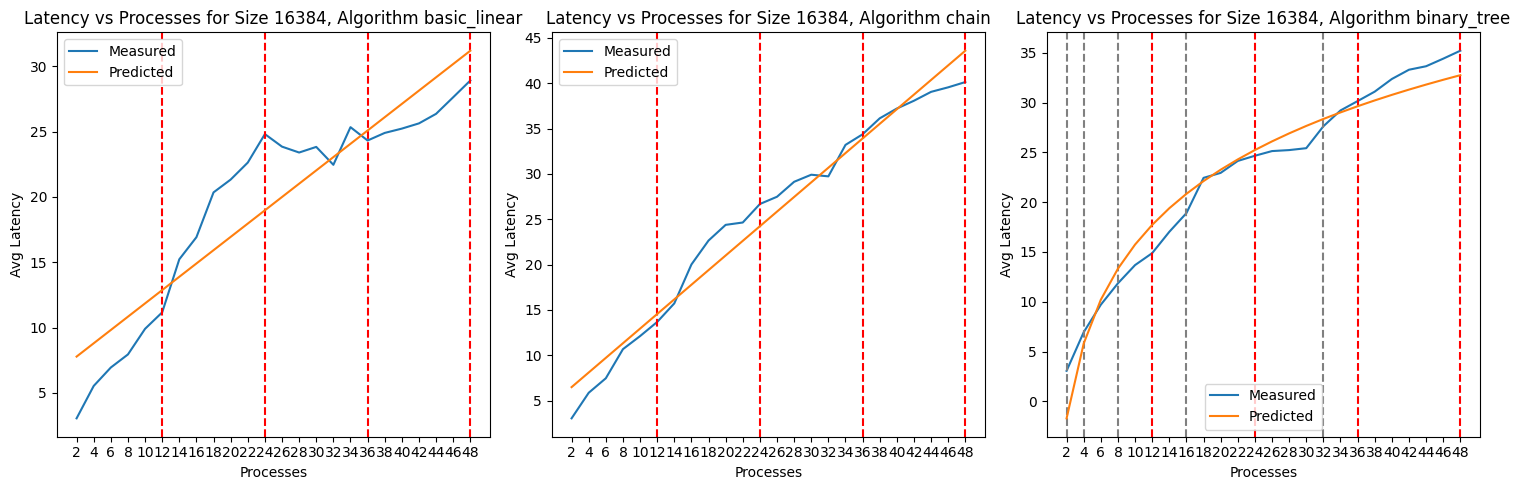

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_processes_vs_latency2(bcast_df, 'basic_linear', 1024*16, axs[0])
plot_processes_vs_latency2(bcast_df, 'chain', 1024*16, axs[1])
plot_processes_vs_latency2(bcast_df, 'binary_tree', 1024*16, axs[2])

plot_pred_latency(bcast_df, 'basic_linear', 1024*16, axs[0])
plot_pred_latency(bcast_df, 'chain', 1024*16, axs[1])
plot_pred_latency(bcast_df, 'binary_tree', 1024*16, axs[2], kernel='log2')

plt.tight_layout()
plt.show()        

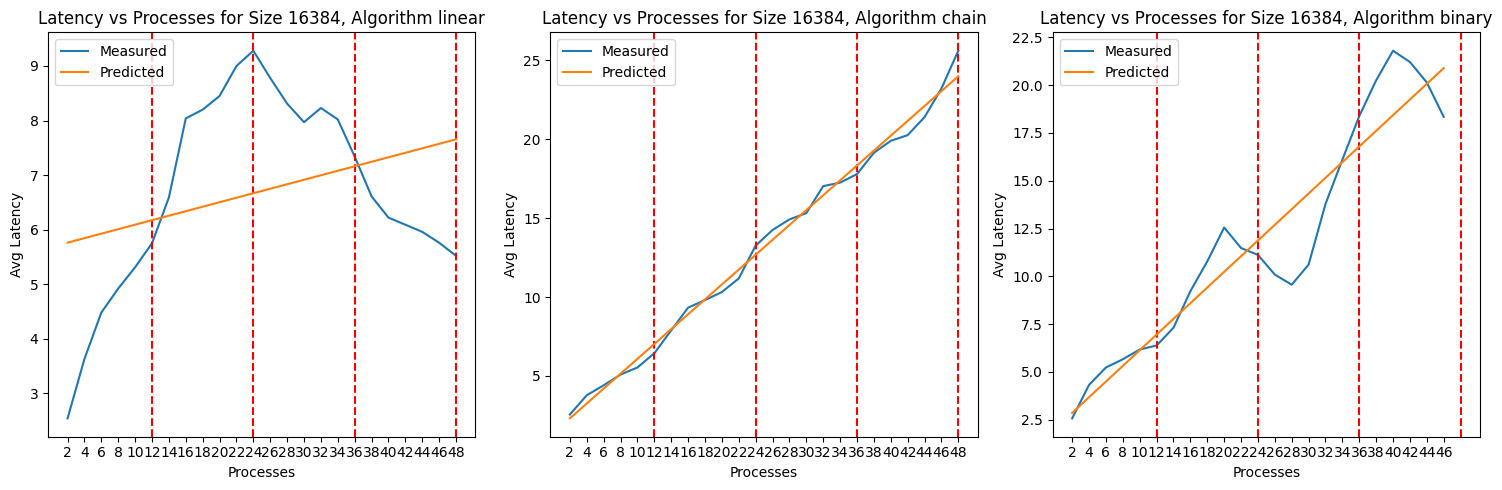

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
plot_processes_vs_latency2(reduce_df, 'linear', 1024*16, axs[0])
plot_processes_vs_latency2(reduce_df, 'chain', 1024*16, axs[1])
plot_processes_vs_latency2(reduce_df, 'binary', 1024*16, axs[2])

plot_pred_latency(reduce_df, 'linear', 1024*16, axs[0])
plot_pred_latency(reduce_df, 'chain', 1024*16, axs[1])
plot_pred_latency(reduce_df, 'binary', 1024*16, axs[2])

plt.tight_layout()
plt.show()